In [1]:
import numpy as np
import pandas as pd
from pandas_geojson import read_geojson
import os

In [2]:
###############################################################
# CENSUS TRACT LEVEL ROW SUM STATS FROM STATE-LEVEL HPMS 2017 #
###############################################################
## DATASETS
    # 2017 HPMS
    # 2020 Census Tracts
# JESSICA LAZARUS
# BERKELEY LAB
# ADAPTED FROM: 0_clean_hpms_arnold.do BY NATALIE POPOVICH
# LAST UPDATED: March 11, 2024
###############################################################

In [3]:
# Set working directory
working_directory = "C:/FHWA_R2/Network"
os.chdir(working_directory)

# Define global variables
clean_data_folder = "CleanData"
raw_data_folder = "RawData"
hpms_folder = "RawData/HPMS2017"
output_date = "2024"

In [4]:

def read_geojson_df(filename):
    df = read_geojson(filename)
    df2 = pd.DataFrame.from_dict(df['features'])
    objects = [x for x in df2['properties']]
    object_df = pd.DataFrame.from_dict(objects)
    return object_df
    
def compile_state_data(hpms_folder,override=False):
    if os.path.exists("hpms.csv")&(override==False):
        return pd.read_csv("hpms.csv")
    else:
        # Read cleaned data from the sample
        hpms_files = [file for file in os.listdir(hpms_folder) if file.endswith(".geojson")]
        files_df = pd.DataFrame({"filename": hpms_files})
        files_df.to_csv("files.csv", index=False) 
        
        obs = len(files_df)
        
        # Prepare data files
        keep_cols = ["f_system","nhs", "through_la", "geoid", "aland", "awater", "urban_code", "length","lanemiles", "route_id", "psr", "state_code", "iri"]
        
        for i in range(obs):
            file_path = os.path.join(hpms_folder, files_df.iloc[i]["filename"])
            df = read_geojson_df(file_path)
            df.columns = df.columns.str.lower()
            these_cols = keep_cols.copy()
            these_cols.extend(df.columns[df.columns.str.contains('aadt')])
            these_cols.extend(df.columns[df.columns.str.contains('speed')])
            these_cols.extend(df.columns[df.columns.str.contains( "access_con")])
            df = df[these_cols]
            df['state'] = files_df.iloc[i]["filename"].split('2017')[0]
            save_path = f"save{i}.csv" 
            df.to_csv(save_path, index=False)

        # Append files
        hpms_df = pd.read_csv("save0.csv") 
        for i in range(1, obs):
            save_path = f"save{i}.csv" 
            temp_df = pd.read_csv(save_path)
            hpms_df = pd.concat([hpms_df, temp_df], ignore_index=True)
        
        hpms_df.to_csv("hpms.csv", index=False)
        return hpms_df

In [5]:
# Load hpms data
over_ride = False # set to True if you want to reload and save the hpms data even if it already exists, else False
hpms_df = compile_state_data(hpms_folder,over_ride)

C:\Users\jrlazarus\AppData\Local\Temp\3\ipykernel_28184\4084898396.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("hpms.csv")


In [6]:
hpms_df.head()

,f_system,nhs,through_la,geoid,aland,awater,urban_code,length,lanemiles,route_id,psr,state_code,iri,aadt,aadt_singl,aadt_combi,speed_limi,access_con,state
0,4.0,1.0,4.0,1045020801,19261326.0,0.0,99998.0,159.610451,0.396710,AL0002490000,0.0,1.0,65.0,7750.0,78.0,233.0,0.0,3.0,alabama
1,4.0,1.0,4.0,1045020801,19261326.0,0.0,99998.0,160.967801,0.400084,AL0002490000,0.0,1.0,50.0,7750.0,78.0,233.0,0.0,3.0,alabama
2,4.0,1.0,4.0,1045020801,19261326.0,0.0,99998.0,69.770964,0.173415,AL0002490000,0.0,1.0,90.0,7750.0,78.0,233.0,0.0,3.0,alabama
3,4.0,1.0,4.0,1045020801,19261326.0,0.0,99998.0,160.967784,0.400084,AL0002490000,0.0,1.0,68.0,7750.0,78.0,233.0,0.0,3.0,alabama
4,4.0,1.0,4.0,1045020801,19261326.0,0.0,99998.0,160.968275,0.400085,AL0002490000,0.0,1.0,51.0,4800.0,48.0,144.0,45.0,3.0,alabama


In [7]:
#############################################
# Data quality checks                       #
#############################################
output_columns = ['f_system','lanemiles','through_la','iri','access_con','nhs']

print("Columns with null values: {}".format(hpms_df.columns[hpms_df.isnull().sum()>0]))

print(hpms_df.dtypes)
for c in hpms_df.columns:
    print(c)
    if c =='route_id':
        print(hpms_df[c].unique())
    else:
        print(hpms_df.sort_values(c)[c].unique())
    if c in output_columns:
        print(hpms_df[c].describe())
        print("Missing/Zero-valued {}: {}%".format(c,np.round(100*hpms_df.loc[hpms_df[c]==0].shape[0]/hpms_df.shape[0],4)))
        if c in ['access_con','f_system','through_la']:
            print(hpms_df[c].value_counts())

Columns with null values: Index([], dtype='object')
f_system      float64
nhs           float64
through_la    float64
geoid           int64
aland         float64
awater        float64
urban_code    float64
length        float64
lanemiles     float64
route_id       object
psr           float64
state_code    float64
iri           float64
aadt          float64
aadt_singl    float64
aadt_combi    float64
speed_limi    float64
access_con    float64
state          object
dtype: object
f_system
[0. 1. 2. 3. 4. 5. 6. 7.]
count    1.482969e+07
mean     3.592259e+00
std      1.247110e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      7.000000e+00
Name: f_system, dtype: float64
Missing/Zero-valued f_system: 0.0003%
f_system
3.0    4442948
5.0    4372644
4.0    3797416
1.0    1565906
2.0     645866
7.0       3508
6.0       1358
0.0         40
Name: count, dtype: int64
nhs
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
count    1.482969e+07
mean     4.454789e-01
s

In [23]:
def check_iri_x_f_system(df,iri_column = 'iri', metric='miles',print=True):
    result = {}
    for f in [1,2,3,4,5,6,7]:
        this = df.loc[df.f_system==f].copy()
        this['iri_bin'] = pd.cut(this[iri_column],[-0.1,0,59.99,94,119,144,170,194,220,this.iri.max()])
        this['miles'] = this['length']/ 1609.34
        rural = this.loc[this.urban_code.isin(["99998","99999"])].copy()
        urban = this.loc[this.urban_code.isin(["99998","99999"])==False].copy()
        result[f]={'urban':pd.crosstab(urban['state'],urban['iri_bin'],urban[metric].fillna(0), aggfunc="sum"),
                  'rural':pd.crosstab(rural['state'],rural['iri_bin'],rural[metric].fillna(0), aggfunc="sum")}
        if print:
            print("Missing IRI f{}: {}% urban (n={}), {}% NHS (n={})".format(f,
                                                                      np.round(100*urban.loc[urban[iri_column]==0].shape[0]/urban.shape[0],2),
                                                                      urban.shape[0],
                                                                     np.round(100*urban.loc[(urban[iri_column]==0)&(urban['nhs']>0)].shape[0]/urban.loc[urban.nhs>0].shape[0],2),
                                                                           urban.loc[urban.nhs>0].shape[0] ))
            print('All iri stats:')
            print(this[iri_column].describe())
            print('NHS iri stats:')
            print(this.loc[this.nhs>0,iri_column].describe())
            if rural.shape[0]>0:
                print("Missing f{}: {}% rural (n={})".format(f, np.round(100*rural.loc[rural[iri_column]==0].shape[0]/rural.shape[0],2),rural.shape[0]))
    return result

In [9]:
print('Lanes')
hpms_df['miles'] = hpms_df['length']/ 1609.34
lanes_summary = hpms_df.loc[hpms_df.through_la>12].groupby(['state','route_id','through_la']).sum()[['lanemiles','miles']].reset_index()
print(lanes_summary.loc[lanes_summary.miles>0.5])

print("IRI")
# IRI (International Roughness Index)
# Description: IRI is the road roughness index most commonly used worldwide for evaluating and managing road systems. 
# Road roughness is the primary indicator of the utility of a highway network to road users. 
# IRI is defined as a statistic used to estimate the amount of roughness in a measured longitudinal profile.
# Use: For investment requirements modeling to estimate pavement deterioration, section deficiencies, and necessary improvements, in cost allocation studies, in pavement condition trends, and for other analysis purposes including NHS performance. 
# Also, for performance measure calculation for pavement condition on the NHS.
# Extent: All NHS and principal arterial sections, and rural minor arterial Sample Panel sections; --> (hpms_df['nhs']==1)&(hpms_df['f_system'].isin([1,2,3]))
# optional for urban minor arterial, major collector, and minor collector Sample Panel sections and rural major collector Sample Panel sections.
iri_x_f_system = check_iri_x_f_system(hpms_df,iri_column='iri')

print('N = {}, lanemiles = {}'.format(hpms_df.shape[0], hpms_df.lanemiles.sum()))
print('99.99th percentile: {} (n={}, lanemiles={})'.format(hpms_df['iri'].quantile(0.9999),
                                             hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.9999)].shape[0],
                                                          hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.9999)].lanemiles.sum()))
print(hpms_df.loc[hpms_df.iri>1000].shape[0], hpms_df.shape[0])
print(hpms_df.loc[hpms_df.iri>1000].lanemiles.sum(), hpms_df.lanemiles.sum())
print('99.9th percentile: {} (n={}, lanemiles={})'.format(hpms_df['iri'].quantile(0.999),
                                             hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.999)].shape[0],
                                                          hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.999)].lanemiles.sum()))
print('99th percentile: {} (n={}, lanemiles={})'.format(hpms_df['iri'].quantile(0.99),
                                             hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.99)].shape[0],
                                                          hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.99)].lanemiles.sum()))
print('95th percentile: {} (n={}, lanemiles={})'.format(hpms_df['iri'].quantile(0.95),
                                             hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.95)].shape[0],
                                                          hpms_df.loc[hpms_df.iri>hpms_df['iri'].quantile(0.95)].lanemiles.sum()))

print("Access control")
# Access_Control (Access Control)
# Description: The degree of access control for a given section of road.
# Use: For investment requirements modeling to calculate capacity and estimate type of design, in truck size and weight studies, and for national highway database purposes.
# Extent: All principal arterials and Sample Panel sections; optional for other non-principal arterial sections beyond the limits of the Sample Panel.
# Code Description
# 1 Full Access Control: Preference given to through traffic movements by providing interchanges with selected public roads, and by prohibiting crossing at-grade and direct driveway connections (i.e., limited access to the facility).
# 2 Partial Access Control: Preference given to through traffic movement. In addition to interchanges, there may be some crossings at-grade with public roads, but, direct private driveway connections have been minimized through the use of frontage roads or other local access restrictions. Control of curb cuts is not access control.
# 3 No Access Control: No degree of access control exists (i.e., full access to the facility is permitted).
print(pd.crosstab(hpms_df['f_system'],hpms_df['access_con']))

Lanes
         state          route_id  through_la   lanemiles      miles
0      arizona             I 010        13.0   37.313857   2.870297
1      arizona             S 202        13.0   38.719581   2.978429
2   california         SHS_005_P        13.0   59.808602   4.600662
3   california         SHS_005_P        14.0  135.101829   9.650131
4   california         SHS_005_P        15.0   17.242786   1.149519
5   california         SHS_005_P        16.0    9.750398   0.609400
6   california         SHS_015_P        13.0   46.821087   3.601622
7   california         SHS_015_P        14.0   14.210517   1.015037
9   california         SHS_057_P        13.0   20.339048   1.564542
10  california         SHS_057_P        14.0   15.674117   1.119580
11  california         SHS_060_P        13.0    7.346306   0.565100
12  california         SHS_060_P        14.0   24.563778   1.754556
13  california         SHS_060_P        15.0   11.872947   0.791530
15  california         SHS_080_P        13

<Axes: title={'center': 'iri'}, xlabel='f_system'>

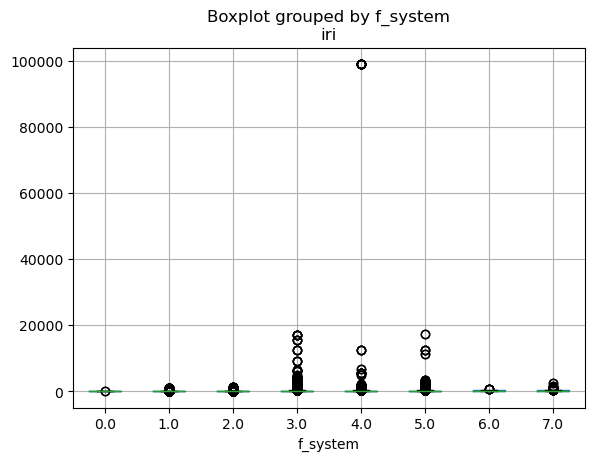

In [10]:
hpms_df.boxplot('iri',by='f_system')

In [11]:
lanes_summary = hpms_df.loc[(hpms_df.through_la>14)].groupby(['state','route_id','through_la']).sum()[['lanemiles','miles']].reset_index()
lanes_summary

,state,route_id,through_la,lanemiles,miles
0,california,SHS_005_P,15.0,17.242786,1.149519
1,california,SHS_005_P,16.0,9.750398,0.609400
2,california,SHS_015_P,16.0,6.511014,0.406938
3,california,SHS_060_P,15.0,11.872947,0.791530
4,california,SHS_080_P,16.0,0.174420,0.010901
5,california,SHS_080_P,17.0,12.429445,0.731144
6,california,SHS_080_P,24.0,2.714416,0.113101
7,california,SHS_080_P,25.0,2.744878,0.109795
8,california,SHS_210_P,15.0,14.204681,0.946979
9,california,SHS_210_P,16.0,1.747356,0.109210


In [31]:
#############################################
# Remove Outliers & Missing Data            #
#############################################

# Number of lanes
# Table: Urban highways with the most lanes:
# https://www.fhwa.dot.gov/policyinformation/tables/01.pdf
# Min number of lanes in table is 12 --> Setting all lane counts greater than 13 to 13, except for those in the table

hpms_df['lanes']=hpms_df['through_la'].copy()
hpms_df.loc[(hpms_df['through_la'] > 13),'lanes']=13
# Georgia ( I-75 (401) - 15 lanes)
# Arizona
hpms_df.loc[(hpms_df['through_la'] > 12) & (hpms_df['state']=='arizona') & (hpms_df['route_id'].str.contains("010")), 'lanes'] = 13
# California
hpms_df.loc[(hpms_df['through_la'] > 13) & (hpms_df['state']=='california') & (hpms_df['route_id'].str.contains("405")), 'lanes'] = 14
# Georgia
hpms_df.loc[(hpms_df['through_la'] > 14) & (hpms_df['state'] =='georgia') & (hpms_df['route_id'].str.contains("401")), 'lanes'] = 15
hpms_df.loc[(hpms_df['through_la'] > 13) & (hpms_df['state'] =='georgia') & (hpms_df['route_id'].str.contains("403")), 'lanes'] = 14
# Maryland
hpms_df.loc[(hpms_df['through_la'] > 13) & (hpms_df['state'] =='marlyand') & (hpms_df['route_id'].str.contains("895")), 'lanes'] = 14
# New Jersey
hpms_df.loc[(hpms_df['through_la'] > 13) & (hpms_df['state'] =='newjersey') & (hpms_df['route_id'].str.contains("095")), 'lanes'] = 14

# update lanemiles
hpms_df['laneMiles'] = hpms_df['lanes']*hpms_df['length'] / 1609.34

# Speed limit
hpms_df['speed_limit']=hpms_df.speed_limi.copy()
hpms_df.loc[hpms_df.speed_limi>85,'speed_limit']=85

# IRI
# remove iri records for non-nhs roads with f_system > 4
hpms_df['iri_clean'] = hpms_df.iri * ((hpms_df.f_system.isin([1,2,3]))|(hpms_df.nhs>0)).astype(int)

# replace outliers with outer upper end of Tukey fence
q1 = hpms_df.loc[(hpms_df.f_system>0)&(hpms_df.iri_clean>0),'iri_clean'].quantile(0.25)
q3 = hpms_df.loc[(hpms_df.f_system>0)&(hpms_df.iri_clean>0),'iri_clean'].quantile(0.75)
iqr = q3-q1
inner_fence = 1.5*iqr
outer_fence = 3*iqr
    
#inner fence lower and upper end
inner_fence_le = q1-inner_fence
inner_fence_ue = q3+inner_fence

#outer fence lower and upper end
outer_fence_le = q1-outer_fence
outer_fence_ue = q3+outer_fence
print(outer_fence_le,inner_fence_le,inner_fence_ue,outer_fence_ue)
print(hpms_df.loc[hpms_df.iri_clean>0,'iri_clean'].quantile(0.99))
print(hpms_df.loc[hpms_df.iri_clean>outer_fence_ue].shape[0],hpms_df.loc[hpms_df.iri_clean>outer_fence_ue].shape[0]/hpms_df.shape[0])

-164.0 -51.5 248.5 361.0
382.0
82644 0.005572875919287839


<Axes: title={'center': 'iri_clean'}, xlabel='f_system'>

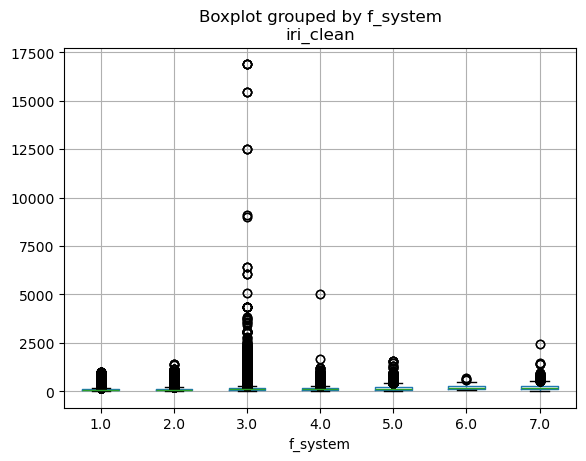

In [13]:
hpms_df.loc[(hpms_df.f_system>0)&(hpms_df.iri_clean>0)].boxplot('iri_clean',by='f_system')

<Axes: title={'center': 'iri_clean'}, xlabel='f_system'>

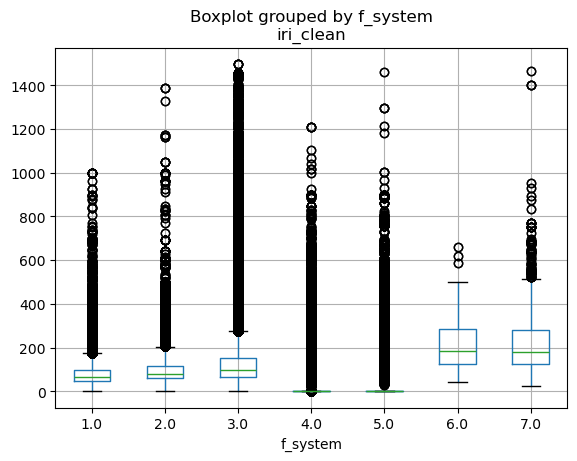

In [14]:
hpms_df.loc[(hpms_df.f_system>0)&(hpms_df.iri_clean<1500)&(hpms_df.iri>0)].boxplot('iri_clean',by='f_system')

<Axes: title={'center': 'iri'}, xlabel='f_system'>

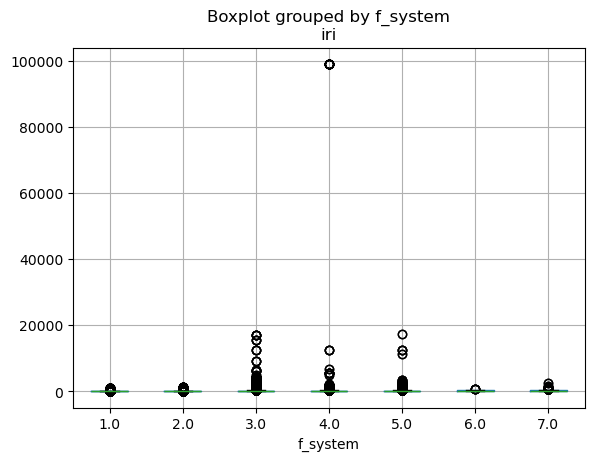

In [17]:
# uncleaned IRI boxplots by F_system
hpms_df.loc[(hpms_df.iri>0)&(hpms_df.f_system>0)].boxplot('iri',by='f_system')

<Axes: title={'center': 'iri'}, xlabel='f_system'>

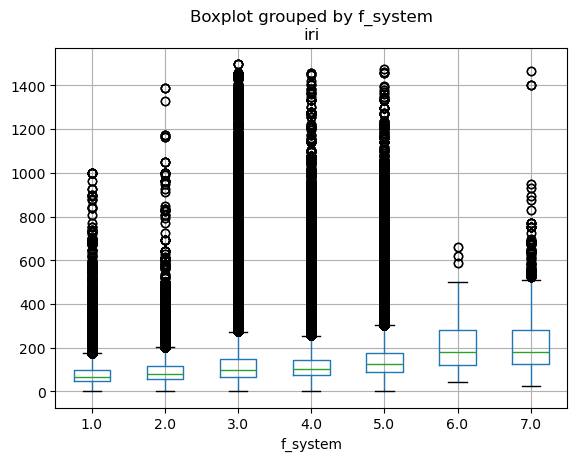

In [18]:
hpms_df.loc[(hpms_df.iri<1500)&(hpms_df.iri>0)&(hpms_df.f_system>0)].boxplot('iri',by='f_system')

In [24]:
# replace iri outliers with outer upper end of Tukey fence
hpms_df.loc[hpms_df.iri>outer_fence_ue,'iri_clean'] = outer_fence_ue

# check distribution of iri by lanemiles for each state & f_system class
iri_x_f_system2 = check_iri_x_f_system(hpms_df,iri_column='iri_clean',print=False)
iri_x_f_system_lanemiles = check_iri_x_f_system(hpms_df,iri_column='iri_clean',metric='laneMiles',print=False)

In [25]:
iri_x_f_system2

{1: {'urban': iri_bin        (-0.1, 0.0]  (0.0, 59.99]  (59.99, 94.0]  (94.0, 119.0]  \
  state                                                                    
  alabama         763.668994   1198.999878     441.548427     138.384195   
  alaska           84.706738    496.731689     821.965934     363.401717   
  arizona         634.166786   1378.398230     564.691104     185.481028   
  arkansas        589.291375    646.708977     504.395961     159.434255   
  california       66.103357   1358.471565    1602.819086     731.158496   
  colorado        584.622309    381.705527     787.242326     362.503014   
  connecticut     562.858185    342.434863     218.988699      70.208110   
  delaware         89.069722      4.998385      38.478585      17.087821   
  district         25.482783      0.000000       5.591166       0.000000   
  florida        1454.943317   1837.713611     720.540623     111.575451   
  georgia        1250.937638   1100.342427     890.063134     274.772813   


<Axes: title={'center': 'speed_limi'}, xlabel='f_system'>

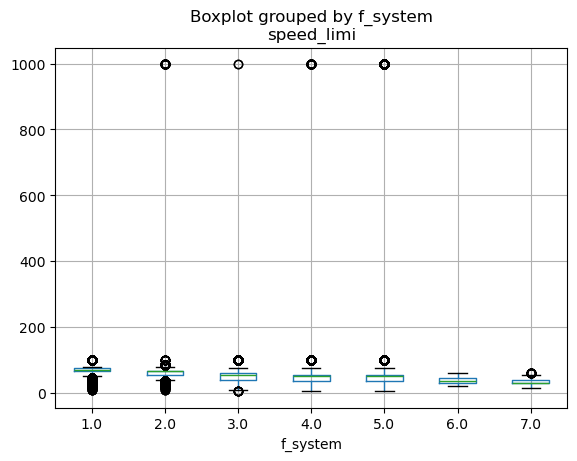

In [35]:
hpms_df.loc[(hpms_df.speed_limi>0)&(hpms_df.f_system>0)].boxplot('speed_limi',by='f_system')

<Axes: title={'center': 'speed_limit'}, xlabel='f_system'>

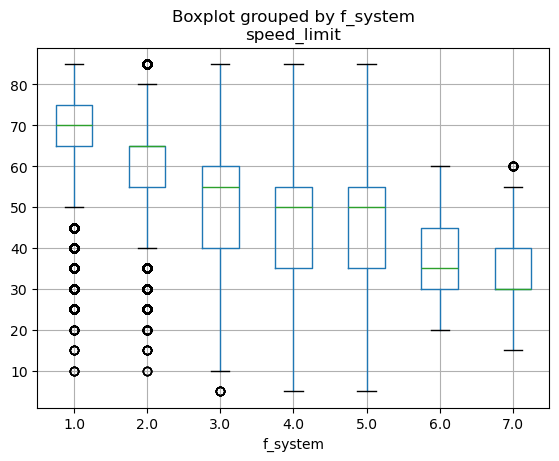

In [34]:
hpms_df.loc[(hpms_df.speed_limit>0)&(hpms_df.f_system>0)].boxplot('speed_limit',by='f_system')

In [36]:
hpms_df.rename(columns={'geoid': 'tract','access_con':'access_control'}, inplace=True)
hpms_df = hpms_df.sort_values(['tract', 'f_system', 'length', 'lanes'])  # sort data

In [37]:
hpms_df.columns

Index(['f_system', 'nhs', 'through_la', 'tract', 'aland', 'awater',
       'urban_code', 'length', 'lanemiles', 'route_id', 'psr', 'state_code',
       'iri', 'aadt', 'aadt_singl', 'aadt_combi', 'speed_limi',
       'access_control', 'state', 'miles', 'lanes', 'laneMiles', 'iri_clean',
       'speed_limit'],
      dtype='object')

## Metric Computation

In [91]:
#############################################
# Metric computation                        #
#############################################
# get final data table with one row per tract and total laneMiles
final_df = hpms_df[['tract', 'aland', 'awater','state','laneMiles']].groupby(
    ['tract', 'aland', 'awater','state']).sum().reset_index()
# merge count of hpms observations (N) per tract
final_df = final_df.merge(hpms_df[['tract','state','lanes']].groupby(['tract','state']).count().reset_index().rename(columns={'lanes':'N'}),
                          how='left',left_on=['state','tract'],right_on=['state','tract'])
final_df.shape

(85394, 6)

In [92]:
# Average IRI
# numerator: lane miles-weighted sum of iri
hpms_df['iri_x_laneMiles']=hpms_df['iri_clean']*hpms_df['laneMiles'] 
# merge denominator: sum of laneMiles on segments with nonzero iri
final_df = final_df.merge(hpms_df.loc[hpms_df.iri_clean>0,['state','tract','iri_x_laneMiles','laneMiles']].rename(
    columns={'laneMiles':'iri_laneMiles'}).groupby(['state','tract']).sum().reset_index(),
                          how='left',left_on=['state','tract'],right_on=['state','tract']) 
final_df['avg_iri']=final_df['iri_x_laneMiles']/final_df['iri_laneMiles']

In [93]:
# Percent road by F_System
count_f_system = pd.crosstab([hpms_df.loc[hpms_df.f_system>0,'state'],hpms_df.loc[hpms_df.f_system>0,'tract']],
                                      hpms_df.loc[hpms_df.f_system>0,'f_system']).reset_index()
final_df = final_df.merge(count_f_system,how='left',left_on=['state','tract'],right_on=['state','tract'])

sum_laneMiles_x_f_system = pd.crosstab([hpms_df.loc[hpms_df.f_system>0,'state'],hpms_df.loc[hpms_df.f_system>0,'tract']],
                                       hpms_df.loc[hpms_df.f_system>0,'f_system'],
                                       hpms_df.loc[hpms_df.f_system>0,'laneMiles'].fillna(0), aggfunc="sum").reset_index().rename(columns={x:'laneMiles_{}'.format(x) for x in hpms_df.f_system.unique()})
final_df = final_df.merge(sum_laneMiles_x_f_system,how='left',left_on=['state','tract'],right_on=['state','tract'])
print(final_df.shape)
final_df['N_f_system'] = final_df[[1,2,3,4,5,6,7]].sum(axis=1)
final_df['total_laneMiles_f_system'] = final_df[['laneMiles_{}'.format(x) for x in hpms_df.f_system.unique() if x>0]].sum(axis=1)

for f in [1,2,3,4]:
    final_df['percent_road_f_system_{}'.format(f)] = final_df[f]/final_df['N_f_system']
    final_df['percent_laneMiles_f_system_{}'.format(f)] = final_df['laneMiles_{}.0'.format(f)].fillna(0)/final_df['total_laneMiles_f_system']

final_df['percent_road_f_system_5_7'] = final_df[[5,6,7]].sum(axis=1)/final_df['N_f_system']
final_df['percent_laneMiles_f_system_5_7'] = final_df[['laneMiles_{}.0'.format(f) for f in [5,6,7]]].fillna(0).sum(axis=1)/final_df['total_laneMiles_f_system']

(85394, 23)


In [94]:
# Percent full/partial access control (full = 1, partial = 2)
hpms_df['full_access_x_laneMiles']=(hpms_df['access_control']==1).astype(int)*hpms_df['laneMiles']
hpms_df['partial_access_x_laneMiles']=(hpms_df['access_control']==2).astype(int)*hpms_df['laneMiles']
final_df = final_df.merge(hpms_df[['state','tract','full_access_x_laneMiles','partial_access_x_laneMiles']].groupby(['state','tract']).sum().reset_index(),how='left',
                          left_on=['state','tract'],right_on=['state','tract'])
final_df['pct_controlf']=final_df['full_access_x_laneMiles']/final_df['laneMiles']
final_df['pct_controlp']=final_df['partial_access_x_laneMiles']/final_df['laneMiles']

In [95]:
# Lane mile density
final_df['lane_mile_density']=4047*final_df['laneMiles']/final_df['aland']
final_df.loc[final_df.aland==0,'lane_mile_density']=0

In [96]:
final_df.columns

Index([                         'tract',                          'aland',
                               'awater',                          'state',
                            'laneMiles',                              'N',
                      'iri_x_laneMiles',                  'iri_laneMiles',
                              'avg_iri',                              1.0,
                                    2.0,                              3.0,
                                    4.0,                              5.0,
                                    6.0,                              7.0,
                        'laneMiles_1.0',                  'laneMiles_2.0',
                        'laneMiles_3.0',                  'laneMiles_4.0',
                        'laneMiles_5.0',                  'laneMiles_6.0',
                        'laneMiles_7.0',                     'N_f_system',
             'total_laneMiles_f_system',        'percent_road_f_system_1',
         'percent_laneMil

In [97]:
final_df[['avg_iri', 'pct_controlf', 'pct_controlp',
          'percent_road_f_system_1','percent_road_f_system_2', 'percent_road_f_system_3','percent_road_f_system_4','percent_road_f_system_5_7',
          'percent_laneMiles_f_system_1','percent_laneMiles_f_system_2','percent_laneMiles_f_system_3','percent_laneMiles_f_system_4','percent_laneMiles_f_system_5_7',
          'lane_mile_density']].describe()

,avg_iri,pct_controlf,pct_controlp,percent_road_f_system_1,percent_road_f_system_2,percent_road_f_system_3,percent_road_f_system_4,percent_road_f_system_5_7,percent_laneMiles_f_system_1,percent_laneMiles_f_system_2,percent_laneMiles_f_system_3,percent_laneMiles_f_system_4,percent_laneMiles_f_system_5_7,lane_mile_density
count,63506.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000,85394.000000
mean,133.786480,0.098101,0.044467,0.076308,0.042978,0.301881,0.294023,0.284810,0.073867,0.039036,0.231550,0.311357,0.344190,0.028279
std,72.899143,0.188365,0.137839,0.178045,0.134626,0.305390,0.276480,0.265045,0.174353,0.125565,0.264321,0.280066,0.281867,0.032868
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81.658298,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.076923,0.000000,0.000000,0.000000,0.065673,0.109321,0.005374
50%,113.914297,0.000000,0.000000,0.000000,0.000000,0.240000,0.222222,0.212651,0.000000,0.000000,0.146371,0.256957,0.300419,0.018413
75%,167.498360,0.109343,0.000000,0.000000,0.000000,0.541667,0.454758,0.420000,0.000000,0.000000,0.394616,0.477839,0.524023,0.039404
max,1270.794620,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.623601


In [98]:
final_df.to_csv('network_microtype_metrics.csv')